In [1]:
import json, os, tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from matplotlib import cm, patches

def analyze(path):
    js = json.load(open(path))
    df = pd.DataFrame(js['rmsds']).T
    df['rot_rmsd'] = (df['rmsd']**2 - df['tr_rmsd']**2)**0.5
    df['grid_offset'] = (df['tr_grid_offset']**2 + df['rot_grid_offset']**2)**0.5
    tim = pd.DataFrame(js['timings']).T
    return df, tim
def analyze_pde10a(path):
    df = pd.read_csv('../paper_results/docking/gnina/pde10a/default.csv')
    pdb_ids = df.name[df.rmsd == df.rmsd]
    df, tim = analyze(path)
    df = df.loc[pdb_ids]
    tim = tim.loc[['preprocess'] + list(pdb_ids)]
    entry = dict(df.median()) | {'pct<2': (df.rmsd < 2).mean()} | dict(tim.sum() / (len(tim) - 1))
    return df, tim, entry
def get_histogram(data, count=10):
    bins = np.linspace(np.min(data), np.max(data), count)
    counts, bins = np.histogram(data, bins)
    #return (bins[1:] + bins[:-1])/2, counts
    return bins[1:], np.cumsum(counts) / np.sum(counts)

## Figure 4 - decoy set

In [2]:
pdb_ids = open('../splits/timesplit_test').read().split('\n')[:-1]
dfs = []
for pdb_id in tqdm.tqdm(pdb_ids):
    path = f'../data/PDBBind_processed/{pdb_id}/{pdb_id}_poses.csv'
    if not os.path.exists(path): 
        print(path)
        continue
    df = pd.read_csv(path)
    dfs.append(df[1:])
big_df = pd.concat(dfs)

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 257/363 [00:05<00:02, 52.99it/s]

../data/PDBBind_processed/6a73/6a73_poses.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 363/363 [00:07<00:00, 50.86it/s]


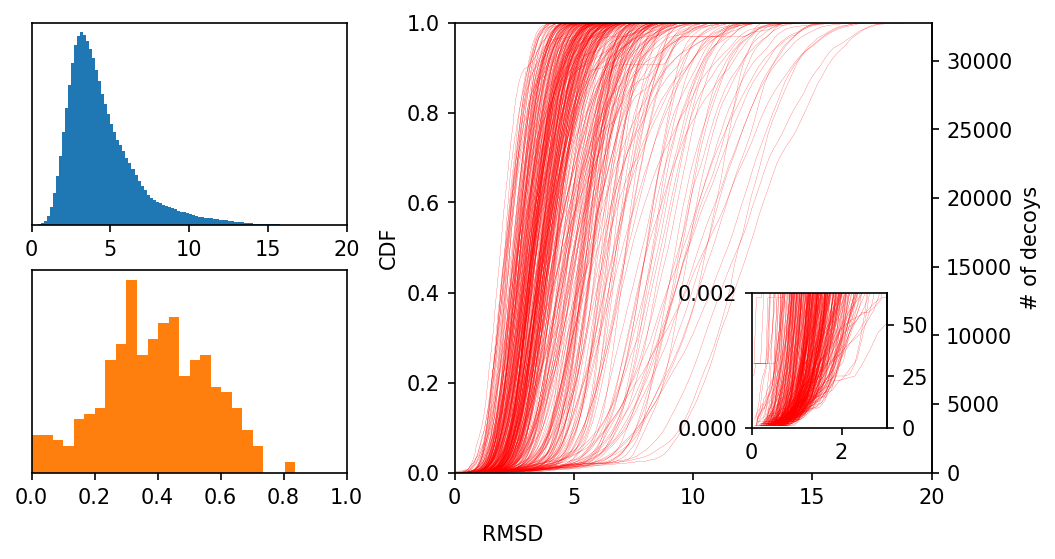

In [3]:
fig = plt.figure(figsize=(6, 3), dpi=150)
ax = fig.add_axes([0, 0.55, 0.35, 0.45])
_ = ax.hist(big_df.rmsd, bins=100, density=True, zorder=-10)
ax.set_yticks([])
ax.set_xlim(0, 20)
ax.set_rasterization_zorder(0)

ax = fig.add_axes([0, 0, 0.35, 0.45])
_ = ax.hist([df.rmsd.min() for df in dfs], bins=25, density=True, color='#ff7f0e', zorder=-10)
ax.set_yticks([])
ax.set_xlim(0, 1)
ax.set_rasterization_zorder(0)
ax = fig.add_axes([0.47, 0, 0.53, 1])
for i in range(len(dfs)):
    data = dfs[i].rmsd
    x, y = get_histogram(data, count=100)
    ax.plot(x, y, lw=0.1, c='red', zorder=-10)

ax.set_xlim(0, 20)
ax.set_ylim(0, 1)
ax.set_ylabel('CDF')
ax.set_rasterization_zorder(0)

secax = ax.secondary_yaxis('right', functions=(lambda x: x * (32**3 - 1), lambda x: x / (32**3 - 1)))
secax.set_ylabel('# of decoys')

ax = fig.add_axes([0.8, 0.1, 0.15, 0.3])
for i in range(len(dfs)):
    data = [dfs[i].rmsd]
    x, y = get_histogram(data, count=100)
    ax.plot(x, y, lw=0.1, c='red', zorder=-10)
ax.set_xlim(0, 3)
ax.set_ylim(0, 0.002)
ax.set_yticks([0, 0.002])
ax.set_rasterization_zorder(0)


ax.secondary_yaxis('right', functions=(lambda x: x * (32**3 - 1), lambda x: x / (32**3 - 1)))
fig.text(0.5, -0.15, 'RMSD')
fig.savefig('../figures/fig4.pdf', bbox_inches='tight')

In [4]:
print('Median min', np.median([df.rmsd.min() for df in dfs]))
print('Median <2 count', np.median([(df.rmsd <= 2).sum() for df in dfs]))
print('Median <2 pct', np.median([(df.rmsd <= 2).mean() for df in dfs]))

Median min 0.39994027660311493
Median <2 count 526.5
Median <2 pct 0.016067995239112523


## Figure 7 - amortization

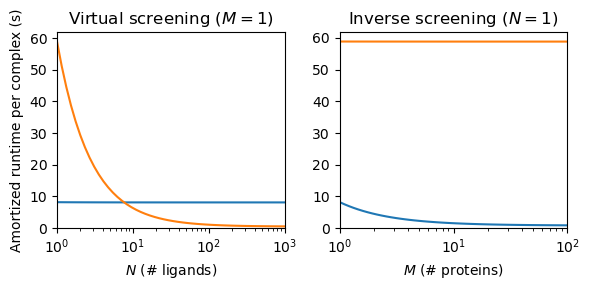

In [10]:
def T_runtime(M, N, R=4608):
    return (65 + 7) * M + (4.3 + 1.6*R) * N + 0.16 * (M*N*R)

def R_runtime(M, N, T=729):
    return (65 + 80*T) * M + (4.3 + 17) * N + 0.65 * (M*N*T)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))

M = 1
N = 10**np.linspace(0, 3)

axs[0].plot(N, T_runtime(M, N) / 1e3 / M / N)
axs[0].plot(N, R_runtime(M, N) / 1e3 / M / N)
axs[0].set_xscale('log')
axs[0].set_ylim(bottom=0)
axs[0].set_xlim(1, 1000)
axs[0].set_title('Virtual screening ($M=1$)')
axs[0].set_xlabel('$N$ (# ligands)')
axs[0].set_ylabel('Amortized runtime per complex (s)')

M = 10**np.linspace(0, 2)
N = 1
axs[1].plot(M, T_runtime(M, N) / 1e3 / M / N)
axs[1].plot(M, R_runtime(M, N) / 1e3 / M / N)
axs[1].set_xscale('log')
axs[1].set_ylim(bottom=0)
axs[1].set_xlim(1, 100)
axs[1].set_title('Inverse screening ($N=1$)')
axs[1].set_xlabel('$M$ (# proteins)')
plt.tight_layout()
plt.savefig('../figures/amortize.pdf')

## Table 7 - model hyperparameters

In [14]:
df = pd.read_csv('../paper_results/docking/gnina/pdbbind/default.csv')
paths = {
    'noise_T': '../paper_results/docking/ESF_N/pdbbind/T_grid2_scaling1.json',
    'noise_R': '../paper_results/docking/ESF_N/pdbbind/R_box9_lmax25.json',
    'T_c3': '../paper_results/docking/sweep/T_c3.json',
    'R_c3': '../paper_results/docking/sweep/R_c3.json',
    'T_c8': '../paper_results/docking/sweep/T_c8.json',
    'R_c8': '../paper_results/docking/sweep/R_c8.json',
    'T_n3': '../paper_results/docking/sweep/T_n3.json',
    'R_n3': '../paper_results/docking/sweep/R_n3.json',
    'T_n8': '../paper_results/docking/sweep/T_n8.json',
    'R_n8': '../paper_results/docking/sweep/R_n8.json',
    'T_r3': '../paper_results/docking/sweep/T_r3.json',
    'R_r3': '../paper_results/docking/sweep/R_r3.json',
    'T_r8': '../paper_results/docking/sweep/T_r8.json',
    'R_r8': '../paper_results/docking/sweep/R_r8.json',
    'T_o1': '../paper_results/docking/sweep/T_o1.json',
    'R_o1': '../paper_results/docking/sweep/R_o1.json',
    'T_o3': '../paper_results/docking/sweep/T_o3.json',
    'R_o3': '../paper_results/docking/sweep/R_o3.json',
}
entries = []
for key in paths:
    df, tim = analyze(paths[key])
    df, tim = df.loc[pdb_ids], tim.loc[pdb_ids].iloc[10:]
    unit_time = sum(tim[k].mean() for k in ['fft', 'cross_correlate', 'readout'] if k in tim)
    entries.append({'name': key, 'pct<2': (df.rmsd < 2).mean(),
                    'rmsd': df['rmsd'].median(), 'grid_offset': df['grid_offset'].median(), 
                    'time': unit_time, 'time_all': tim['all'].mean()})

entries = pd.DataFrame(entries)
entries

,name,pct<2,rmsd,grid_offset,time,time_all
0,noise_T,0.720721,1.104596,0.667066,723.806405,8166.544446
1,noise_R,0.729730,0.997074,0.534659,477.719273,67695.861123
2,T_c3,0.696697,1.073811,0.662194,839.393380,6476.627663
3,R_c3,0.708709,0.982231,0.526632,365.894706,70078.434702
4,T_c8,0.711712,1.154538,0.654507,857.798842,11638.805355
5,R_c8,0.702703,1.085282,0.500840,691.238689,70635.355149
6,T_n3,0.639640,1.272905,0.657907,853.931727,7958.984694
7,R_n3,0.636637,1.126881,0.536447,496.475845,69857.581966
8,T_n8,0.768769,1.066470,0.659533,791.668355,9296.183031
9,R_n8,0.759760,0.946373,0.522523,494.159402,73821.281416


## Table 8 - PDBBind TF

In [5]:
df = pd.read_csv('../paper_results/docking/gnina/pdbbind/default.csv')
pdb_ids = df.name[df.rmsd == df.rmsd]
len(pdb_ids)

333

In [6]:
summary_df = []
for grid in [1, 2]:
    for scaling in [1, 2]:
        path = f'../paper_results/docking/ESF_N/pdbbind/T_grid{grid}_scaling{scaling}.json'
        if not os.path.exists(path): continue
        df, tim = analyze(path)
        df = df.loc[pdb_ids]
        tim = tim.loc[pdb_ids]
        summary_df.append({'grid': grid, 'scaling': scaling} | dict(df.median()) | {'pct<2': (df.rmsd < 2).mean()} | dict(tim.iloc[10:].mean()))
T_summary_df = pd.DataFrame(summary_df)
T_summary_df['protein'] = T_summary_df['protein_model'] + T_summary_df['protein_fft']
T_summary_df['ligand'] = T_summary_df['ligand_model'] + T_summary_df['ligand_fft']
T_summary_df['scaling'] = [17 if g == 2 else 9 for g in T_summary_df['scaling']]
T_summary_df['grid'] = [4608 if g == 2 else 576 for g in T_summary_df['grid']]
T_summary_df['poses'] = T_summary_df['scaling']**3 * T_summary_df['grid']
T_summary_df = T_summary_df[['scaling', 'grid', 'poses', 'tr_grid_offset', 'rot_grid_offset', 'grid_offset', 'rmsd', 'pct<2', 'protein', 'ligand', 'cross_correlate']]
T_summary_df.style.format(precision=2)

,scaling,grid,poses,tr_grid_offset,rot_grid_offset,grid_offset,rmsd,pct<2,protein,ligand,cross_correlate
0,9,576,419904,0.52,0.84,0.98,1.53,0.63,65.49,930.51,100.14
1,17,576,2829888,0.25,0.80,0.84,1.50,0.64,70.14,928.21,122.79
2,9,4608,3359232,0.50,0.42,0.67,1.10,0.72,71.59,7196.50,715.14


## Table 9 - PDBBind RF

In [7]:
summary_df = []
for box in [7, 9, 13]:
    for lmax in [10, 25, 50]:
        path = f'../paper_results/docking/ESF_N/pdbbind/R_box{box}_lmax{lmax}.json'
        if not os.path.exists(path): continue
        df, tim = analyze(path)
        df = df.loc[pdb_ids]
        tim = tim.loc[pdb_ids]
        summary_df.append({'box': box, 'lmax': lmax} | dict(df.median()) | {'pct<2': (df.rmsd < 2).mean()} | dict(tim.iloc[10:].mean()))
    if path == 'results/pdbbind/R_box9_lmax25.json':
        break
        
R_summary_df = pd.DataFrame(summary_df)
R_summary_df['protein'] = R_summary_df['protein_model'] + R_summary_df['protein_coeffs']
R_summary_df['ligand'] = R_summary_df['ligand_model'] + R_summary_df['ligand_coeffs']
R_summary_df['poses'] = R_summary_df['box']**3 * (2*R_summary_df['lmax'] + 1)**3
R_summary_df = R_summary_df[['box', 'lmax', 'poses', 'tr_grid_offset', 'rot_grid_offset', 'grid_offset', 'rmsd', 'pct<2', 'protein', 'ligand', 'fft']]
R_summary_df.style.format(precision=2)

,box,lmax,poses,tr_grid_offset,rot_grid_offset,grid_offset,rmsd,pct<2,protein,ligand,fft
0,7,10,3176523,0.65,0.38,0.80,1.25,0.70,30416.14,85.14,157.71
1,7,25,45499293,0.67,0.15,0.70,1.15,0.69,30957.70,86.97,224.51
2,7,50,353393243,0.65,0.08,0.67,1.16,0.70,31581.85,84.57,704.42
3,9,10,6751269,0.49,0.36,0.64,1.16,0.73,64459.68,85.49,332.81
4,9,25,96702579,0.50,0.15,0.53,1.00,0.73,67131.78,86.75,476.11
5,9,50,751089429,0.51,0.08,0.52,0.98,0.74,63446.87,84.19,1486.88
6,13,10,20346417,0.33,0.37,0.51,1.05,0.74,197644.35,84.59,994.69
7,13,25,291434247,0.33,0.15,0.37,0.90,0.72,200358.28,86.18,1430.25


## Figure 6 - inference hyperparameters

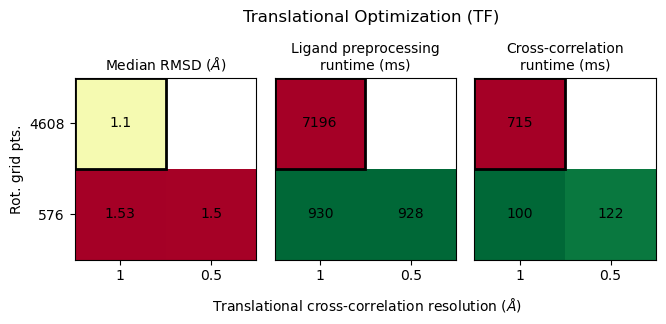

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(7.5,2.5))

z = np.array(list(T_summary_df.rmsd) + [np.nan]).reshape(2,2)
axs[0].imshow(z, cmap='RdYlGn_r', vmin=0.75, vmax=1.5, origin='lower')
axs[0].set_xticks([0,1], [1, 0.5])
axs[0].set_ylabel('Rot. grid pts.')
axs[0].set_yticks([0,1], [576, 4608])
axs[0].set_title('Median RMSD ($\AA$)')
axs[0].title.set_size(10)
for i in range(2):
    for j in range(2):
        if z[i,j] == z[i,j]: axs[0].text(j, i, np.around(z[i,j], 2), ha='center', va='center')

z = np.array(list(T_summary_df.ligand) + [np.nan]).reshape(2,2)
axs[1].imshow(z, cmap='RdYlGn_r', origin='lower')# , vmin=0, vmax=8000)
axs[1].set_xticks([0,1], [1,0.5])

axs[1].set_yticks([])
axs[1].set_title('Ligand preprocessing\nruntime (ms)')
axs[1].title.set_size(10)

for i in range(2):
    for j in range(2):
        if z[i,j] == z[i,j]: axs[1].text(j, i, int(z[i,j]), ha='center', va='center')

z = np.array(list(T_summary_df.cross_correlate) + [np.nan]).reshape(2,2)
axs[2].imshow(z, cmap='RdYlGn_r', origin='lower')#, vmin=0, vmax=15000)
axs[2].set_xticks([0,1], [1,0.5])

axs[2].set_yticks([])
axs[2].set_title('Cross-correlation\nruntime (ms)')
axs[2].title.set_size(10)

for i in range(2):
    for j in range(2):
        if z[i,j] == z[i,j]: axs[2].text(j, i, int(z[i,j]), ha='center', va='center')

for ax in axs: 
    rect = patches.Rectangle((-0.5, 0.5), 1, 1, facecolor='none', edgecolor='k', linewidth=2)
    ax.add_patch(rect)

plt.subplots_adjust(wspace=0.1)
fig.text(0.515, -0.05, 'Translational cross-correlation resolution ($\AA$)', ha='center', va='center')
fig.text(0.52, 1.1, 'Translational Optimization (TF)', ha='center', va='center', fontsize=12)
plt.savefig('../figures/tf_grid.pdf', bbox_inches='tight')

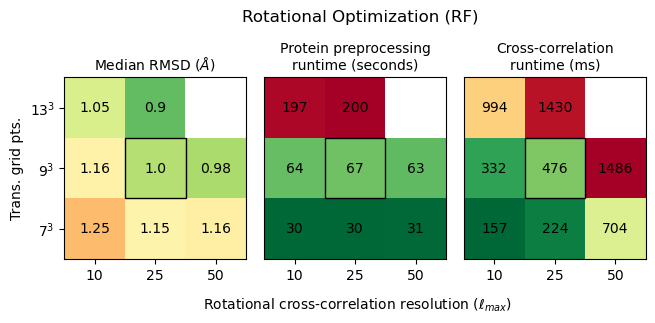

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(7.5,2.5))

z = np.array(list(R_summary_df.rmsd) + [np.nan]).reshape(3,3)
axs[0].imshow(z, cmap='RdYlGn_r', vmin=0.75, vmax=1.5, origin='lower')
axs[0].set_xticks([0,1,2], [10,25,50])
axs[0].set_ylabel('Trans. grid pts.')
axs[0].set_yticks([0,1,2], ["$7^3$","$9^3$","$13^3$"])
axs[0].set_title('Median RMSD ($\AA$)')
axs[0].title.set_size(10)
for i in range(3):
    for j in range(3):
        if z[i,j] == z[i,j]: axs[0].text(j, i, np.around(z[i,j], 2), ha='center', va='center')

z = np.array(list(R_summary_df.protein) + [np.nan]).reshape(3,3)
axs[1].imshow(z, cmap='RdYlGn_r', origin='lower')#, vmin=0.75, vmax=1.5)
axs[1].set_xticks([0,1,2], [10,25,50])

axs[1].set_yticks([0,1,2], [None, None, None])
axs[1].set_yticks([])
axs[1].set_title('Protein preprocessing\nruntime (seconds)')
axs[1].title.set_size(10)

for i in range(3):
    for j in range(3):
        if z[i,j] == z[i,j]: axs[1].text(j, i, int(z[i,j] / 1000), ha='center', va='center')

z = np.array(list(R_summary_df.fft) + [np.nan]).reshape(3,3)
axs[2].imshow(z, cmap='RdYlGn_r', origin='lower')#, vmin=0.75, vmax=1.5)
axs[2].set_xticks([0,1,2], [10,25,50])

axs[2].set_yticks([0,1,2], [None, None, None])
axs[2].set_yticks([])
axs[2].set_title('Cross-correlation\nruntime (ms)')
axs[2].title.set_size(10)

for i in range(3):
    for j in range(3):
        if z[i,j] == z[i,j]: axs[2].text(j, i, int(z[i,j]), ha='center', va='center')

for ax in axs: 
    rect = patches.Rectangle((0.5, 0.5), 1, 1, facecolor='none', edgecolor='k', linewidth=1)
    ax.add_patch(rect)

plt.subplots_adjust(wspace=0.1)
fig.text(0.515, -0.05, 'Rotational cross-correlation resolution ($\ell_{max}$)', ha='center', va='center')
fig.text(0.52, 1.1, 'Rotational Optimization (RF)', ha='center', va='center', fontsize=12)
plt.savefig('../figures/rf_grid.pdf', bbox_inches='tight')

## Table 10 - PDE10A TF

In [8]:
summary_df = []
for grid in [1, 2]:
    for scaling in [1, 2]:
        path = f'../paper_results/docking/ESF_N/pde10a/T_grid{grid}_scaling{scaling}.json'
        if not os.path.exists(path): continue
        df, tim, entry = analyze_pde10a(path)
        summary_df.append({'grid': grid, 'scaling': scaling} | entry)
T_summary_df = pd.DataFrame(summary_df)

T_summary_df['protein'] = T_summary_df['protein_model'] + T_summary_df['protein_fft']
T_summary_df['ligand'] = T_summary_df['ligand_model'] + T_summary_df['ligand_fft']
T_summary_df['scaling'] = [17 if g == 2 else 9 for g in T_summary_df['scaling']]
T_summary_df['grid'] = [4608 if g == 2 else 576 for g in T_summary_df['grid']]
T_summary_df['poses'] = T_summary_df['scaling']**3 * T_summary_df['grid']
T_summary_df = T_summary_df[['scaling', 'grid', 'poses', 'tr_grid_offset', 'rot_grid_offset', 'grid_offset', 'rmsd', 'pct<2', 'protein', 'ligand', 'cross_correlate']]
T_summary_df.style.format(precision=2)

,scaling,grid,poses,tr_grid_offset,rot_grid_offset,grid_offset,rmsd,pct<2,protein,ligand,cross_correlate
0,9,576,419904,0.51,0.88,1.00,1.85,0.56,21.79,760.72,89.32
1,17,576,2829888,0.26,0.89,0.93,2.05,0.50,20.20,756.25,105.93
2,9,4608,3359232,0.50,0.48,0.69,1.11,0.64,20.75,6159.30,736.18
3,17,4608,22639104,0.26,0.44,0.51,1.00,0.73,20.02,6147.18,892.24


## Table 11 - PDE10A RF

In [9]:
summary_df = []
for box in [7, 9, 13]:
    for lmax in [10, 25, 50]:
        path = f'../paper_results/docking/ESF_N/pde10a/R_box{box}_lmax{lmax}.json'
        if not os.path.exists(path): continue
        df, tim, entry = analyze_pde10a(path)
        summary_df.append({'box': box, 'lmax': lmax} | entry)
R_summary_df = pd.DataFrame(summary_df)
R_summary_df['protein'] = R_summary_df['protein_model'] + R_summary_df['protein_coeffs']
R_summary_df['ligand'] = R_summary_df['ligand_model'] + R_summary_df['ligand_coeffs']
R_summary_df['poses'] = R_summary_df['box']**3 * (2*R_summary_df['lmax'] + 1)**3
R_summary_df = R_summary_df[['box', 'lmax', 'poses', 'tr_grid_offset', 'rot_grid_offset', 'grid_offset', 'rmsd', 'pct<2', 'protein', 'ligand', 'cross_correlate']]
R_summary_df.style.format(precision=2)

,box,lmax,poses,tr_grid_offset,rot_grid_offset,grid_offset,rmsd,pct<2,protein,ligand,cross_correlate
0,7,10,3176523,0.72,0.38,0.83,1.60,0.54,475.79,44.09,160.86
1,7,25,45499293,0.57,0.16,0.59,1.21,0.63,548.94,42.33,226.85
2,7,50,353393243,0.65,0.08,0.65,1.30,0.64,635.09,58.64,718.02
3,9,10,6751269,0.46,0.39,0.63,1.05,0.64,1013.86,42.67,327.01
4,9,25,96702579,0.48,0.16,0.51,1.00,0.70,946.17,43.26,465.02
5,9,50,751089429,0.49,0.09,0.50,0.99,0.64,943.13,41.79,1483.21
6,13,10,20346417,0.34,0.41,0.55,1.17,0.64,2798.08,42.20,985.59
7,13,25,291434247,0.33,0.16,0.36,0.96,0.69,2911.93,45.15,1468.89


## Figure 8 - Pareto front

In [10]:
df = pd.read_csv('../paper_results/docking/gnina/pdbbind/default.csv')
pdb_ids = df.name[df.rmsd == df.rmsd]
print(len(pdb_ids))
paths = {
    'T': '../paper_results/docking/ESF/pdbbind/T_grid2_scaling1.json',
    'R': '../paper_results/docking/ESF/pdbbind/R_box9_lmax25.json',
    'noise_T': '../paper_results/docking/ESF_N/pdbbind/T_grid2_scaling1.json',
    'noise_R': '../paper_results/docking/ESF_N/pdbbind/R_box9_lmax25.json'
}
entries = []
for key in paths:
    df, tim = analyze(paths[key])
    df, tim = df.loc[pdb_ids], tim.loc[pdb_ids].iloc[10:]
    unit_time = sum(tim[k].mean() for k in ['fft', 'cross_correlate', 'readout'] if k in tim)
    entries.append({'name': key, 'pct<2': (df.rmsd < 2).mean(),
                    'rmsd': df['rmsd'].median(), 'grid_offset': df['grid_offset'].median(), 
                    'time': unit_time, 'time_all': tim['all'].mean()})

csvs = {
    'default': '../paper_results/docking/gnina/pdbbind/default.csv',
    'score_only': '../paper_results/docking/gnina/pdbbind/score_only.csv',
    'mc5': '../paper_results/docking/gnina/pdbbind/mc5.csv',
    'min5': '../paper_results/docking/gnina/pdbbind/min5.csv',
    'mc5min5': '../paper_results/docking/gnina/pdbbind/mc5min5.csv',
}
for csv in csvs:
    df = pd.read_csv(csvs[csv])
    entries.append({'name': csv, 'pct<2': (df.rmsd < 2).mean(), 'rmsd': df.rmsd.median(), 'time': 1000 * df.time.mean()})
pdbbind_entries = pd.DataFrame(entries).set_index('name')
pdbbind_entries['time'] /= 1000

333


In [11]:
paths = {
    'T': '../paper_results/docking/ESF/pde10a/T_grid2_scaling1.json',
    'R': '../paper_results/docking/ESF/pde10a/R_box9_lmax25.json',
    'noise_T': '../paper_results/docking/ESF_N/pde10a/T_grid2_scaling1.json',
    'noise_R': '../paper_results/docking/ESF_N/pde10a/R_box9_lmax25.json'
}
df = pd.read_csv('../paper_results/docking/gnina/pde10a/default.csv')
pdb_ids = df.name[df.rmsd == df.rmsd]
print(len(pdb_ids))
entries = []
for key in paths:
    df, tim = analyze(paths[key])
    df = df.loc[pdb_ids]
    tim = tim.loc[['preprocess'] + list(pdb_ids)]
    
    unit_time = sum(tim[k].mean() for k in ['cross_correlate', 'readout'])
    entries.append({'name': key, 'pct<2': (df.rmsd < 2).mean(),
                    'rmsd': df['rmsd'].median(), 'grid_offset': df['grid_offset'].median(), 
                    'time': unit_time, 'time_all': tim.sum().sum() / (len(tim) - 1)})

csvs = {
    'default': '../paper_results/docking/gnina/pde10a/default.csv',
    'score_only': '../paper_results/docking/gnina/pde10a/score_only.csv',
    'mc5': '../paper_results/docking/gnina/pde10a/mc5.csv',
    'min5': '../paper_results/docking/gnina/pde10a/min5.csv',
    'mc5min5': '../paper_results/docking/gnina/pde10a/mc5min5.csv',
}
for csv in csvs:
    df = pd.read_csv(csvs[csv])
    df = df.set_index('name').loc[pdb_ids]
    entries.append({'name': csv, 'pct<2': (df.rmsd < 2).mean(), 'rmsd': df.rmsd.median(), 'time': 1000 * df.time.mean()})
pde10a_entries = pd.DataFrame(entries).set_index('name')
pde10a_entries['time'] /= 1000

70


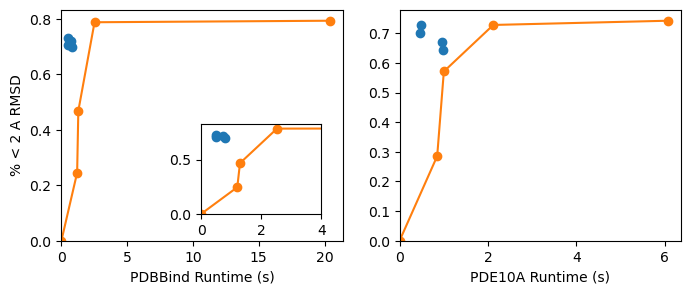

In [12]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].scatter(pdbbind_entries.loc[paths.keys()]['time'], pdbbind_entries.loc[paths.keys()]['pct<2'])
axs[0].plot(*zip(*sorted(zip(
    pdbbind_entries.loc[csvs.keys()]['time'] - pdbbind_entries.loc['score_only'].time, 
    pdbbind_entries.loc[csvs.keys()]['pct<2']
))), 'o-', color='#ff7f0e')
axs[0].set_ylabel('% < 2 A RMSD')
axs[0].set_xlabel('PDBBind Runtime (s)')
axs[0].set_xlim(left=0)
axs[0].set_ylim(bottom=0)
axs[1].scatter(pde10a_entries.loc[paths.keys()]['time'], pde10a_entries.loc[paths.keys()]['pct<2'])
axs[1].plot(*zip(*sorted(zip(
    pde10a_entries.loc[csvs.keys()]['time'] - pde10a_entries.loc['score_only'].time, 
    pde10a_entries.loc[csvs.keys()]['pct<2']
))), 'o-', color='#ff7f0e')
axs[1].set_xlabel('PDE10A Runtime (s)')
axs[1].set_xlim(left=0)
axs[1].set_ylim(bottom=0)

ax = fig.add_subplot([0.3, 0.2, 0.15, 0.3])
ax.scatter(pdbbind_entries.loc[paths.keys()]['time'], pdbbind_entries.loc[paths.keys()]['pct<2'])
ax.plot(*zip(*sorted(zip(
    pdbbind_entries.loc[csvs.keys()]['time'] - pdbbind_entries.loc['score_only'].time, 
    pdbbind_entries.loc[csvs.keys()]['pct<2']
))), 'o-', color='#ff7f0e')
ax.set_xlim(0, 4)
ax.set_ylim(bottom=0)

plt.savefig('../figures/fig6.pdf', bbox_inches='tight')